# Data Preparation

### Task
Parse the json **nyc_geo.json** into the dataframe with the following columns:
- Borough
- Neighborhood
- Latitude
- Longitude

In [53]:
!pip install geopy

In [54]:
import os
import json 
from IPython.display import JSON
import pandas as pd
import numpy as np

#map visualization
import folium

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance

import requests # library to handle requests

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
#get neighborhoods data and put to dataframe
data = 'data/nyc_geo.json'

with open (data, 'r') as f:
    contents = json.loads(f.read())

In [56]:
contents['features'][1]

{'type': 'Feature',
 'id': 'nyu_2451_34572.2',
 'geometry': {'type': 'Point',
  'coordinates': [-73.82993910812398, 40.87429419303012]},
 'geometry_name': 'geom',
 'properties': {'name': 'Co-op City',
  'stacked': 2,
  'annoline1': 'Co-op',
  'annoline2': 'City',
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.82993910812398,
   40.87429419303012,
   -73.82993910812398,
   40.87429419303012]}}

In [57]:
contents['features'][0]['properties']['borough']

'Bronx'

In [58]:
contents['features'][0]['properties']['name']

'Wakefield'

In [59]:
contents['features'][0]['geometry']['coordinates']

[-73.84720052054902, 40.89470517661]

In [60]:
borough=[]
neighborhood=[]
latitude=[]
longitude=[]
for boro in contents['features']:
    borough.append(boro['properties']['borough'])
    neighborhood.append(boro['properties']['name'])
    latitude.append(boro['geometry']['coordinates'][0])
    longitude.append(boro['geometry']['coordinates'][1])

In [61]:
len(longitude)

306

In [62]:
df = pd.DataFrame({'borough':borough,
                   'neighborhood':neighborhood,
                   'latitude':longitude,
                   'longitude':latitude
                  })

In [63]:
df.head()

,borough,neighborhood,latitude,longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [64]:
df.describe()

,latitude,longitude
count,306.000000,306.000000
mean,40.701362,-73.946254
std,0.097498,0.121202
min,40.505334,-74.246569
25%,40.617778,-74.000062
50%,40.702969,-73.932009
75%,40.766645,-73.857525
max,40.908543,-73.708847


In [65]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [23]:


#create a map
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['borough'], df['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 
map_clusters.save("initial.html")
map_newyork

NameError: name 'map_clusters' is not defined

### LYFT PICKUPS

In [66]:
lyft = pd.read_csv('data/other_lyft_b02510.csv')

In [67]:
#one zero, remove it and reset index for looping
lyft = lyft.dropna().reset_index()

In [68]:
lyft['start_lng'].isna().sum()

0

In [69]:
lyft.head()

,index,time_of_trip,start_lat,start_lng,start_location
0,0,2014-09-04T09:51:00,40.64705,-73.77988,POINT(-73.77988 40.64705)
1,1,2014-08-27T21:13:00,40.74916,-73.98373,POINT(-73.98373 40.74916)
2,2,2014-09-04T14:16:00,40.64065,-73.97594,POINT(-73.97594 40.64065)
3,3,2014-09-04T16:08:00,40.75002,-73.99514,POINT(-73.99514 40.75002)
4,4,2014-08-28T02:41:00,40.76715,-73.98636,POINT(-73.98636 40.76715)


In [70]:
lyftdf = df.copy()

In [71]:
#make lyft pickups column
lyftdf['lyft_pickups'] = 0

In [ ]:
# assign lyft pickups to neighborhoods by checking distance from neighborhood
# assign it to neighborhood if its less than 600m from it
# NOTA BENE: THIS TAKES A LONG TIME! 
# lyft frame has 280000 entries, and nbhoods has 306, max order < O(280000 x 306)
for i in range(len(lyft)):   
    pickupcoords = (lyft.at[i, 'start_lat'], lyft.at[i, 'start_lng'])
    for j in range(len(df)):
        nbhoodcoords = (lyftdf.at[j, 'nb latitude'], lyftdf.at[j, 'nb longitude'])
        dist = distance.distance(pickupcoords, nbhoodcoords).m
        if dist < 600:
            lyftdf.at[j, 'lyft_pickups'] += 1
            break

In [ ]:
#lyftdf.to_csv('data/lyftpickups.csv')

In [72]:
lyftdf.head()

,borough,neighborhood,latitude,longitude,lyft_pickups
0,Bronx,Wakefield,40.894705,-73.847201,0
1,Bronx,Co-op City,40.874294,-73.829939,0
2,Bronx,Eastchester,40.887556,-73.827806,0
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0


### HOUSING PRICES DATA

In [30]:
#get housing prices data
febexcel = pd.read_excel('data/nyc_housing_prices_feb_2021.xlsx')
julcsv = pd.read_csv('data/nyc_housing_prices_jul_2020.csv')

In [31]:
#working on these columns a lot
process_cols = ['studio', '1_bedroom', '2_bedroom']

In [32]:
#remove commas and dollar signs so we can count mean
for i in process_cols:
    febexcel[i] = febexcel[i].str.replace(',', '')
    febexcel[i] = febexcel[i].str.replace('$', '')

for i in julcsv.columns[2:6]:
    julcsv[i] = julcsv[i].str.replace(',', '')
    julcsv[i] = julcsv[i].str.replace('$', '')

In [33]:
#realign excel table data because it is not aligned in the end (check febexcel.tail())
#take it all apart first. im sure theres a more elegant way
febexcelstud = febexcel[['neighborhood','studio']].copy()
febexcelonebd = febexcel[['neighborhood.1','1_bedroom']].copy()
febexcelonebd.rename(columns={"neighborhood.1":"neighborhood"}, inplace=True)
febexceltwobd = febexcel[['neighborhood.2', '2_bedroom']].copy()
febexceltwobd.rename(columns={"neighborhood.2":"neighborhood"}, inplace=True)

In [34]:
#drop null values from datasets, otherwise merge will give too many results
febexcelstud.dropna(subset=['studio'], inplace=True)
febexcelonebd.dropna(subset=['1_bedroom'], inplace=True)
febexceltwobd.dropna(subset=['2_bedroom'], inplace=True)

In [35]:
#make existing values floats
febexcelstud['studio'] = febexcelstud['studio'].astype(float)
febexcelonebd['1_bedroom'] = febexcelonebd['1_bedroom'].astype(float)
febexceltwobd['2_bedroom'] = febexceltwobd['2_bedroom'].astype(float)

In [36]:
#merge separated tables on neighborhood
#merge on right because the second and third columns had more values
feb_merged_one = pd.merge(febexcelstud, febexcelonebd, how='right', on='neighborhood')
feb_merged = pd.merge(feb_merged_one, febexceltwobd, how='right', on='neighborhood')

In [37]:
#fill nans with column mean
for i in process_cols:
    feb_merged[i].fillna((feb_merged[i].mean()), inplace=True)

In [38]:
#make new column called mean based on the other values
feb_merged['mean'] = feb_merged.mean(axis=1)

In [39]:
feb_merged.head()

,neighborhood,studio,1_bedroom,2_bedroom,mean
0,Upper West Side,1975.0,2750.0,4350.0,3025.000000
1,Bedford-Stuyvesant,1650.0,1975.0,2200.0,1941.666667
2,Bushwick,1731.0,2150.0,2100.0,1993.666667
3,Upper East Side,1898.0,2395.0,3295.0,2529.333333
4,Williamsburg,2491.0,2500.0,2584.0,2525.000000


In [ ]:
#GREAT SUCCESS! save to file
#feb_merged.to_csv('data/processed_housing_feb2021.csv')

In [40]:
#on to the july 2021 dataset
#spelling error in column name
julcsv.rename(columns={"neigborhood":"neighborhood"}, inplace=True)

In [41]:
#drop borough and 3_bedroom because we dont have that info in the prev dataset
julcsv.drop(columns=['borough', '3_bedroom'], inplace=True)

In [42]:
# red hook is missing a val
julcsv.at[50, 'studio'] = 0

In [43]:
#make those values float
for i in process_cols:
    julcsv[i] = julcsv[i].astype(float)

In [44]:
#red hook again
julcsv.at[50, 'studio'] = julcsv['studio'].mean()

In [45]:
#get mean for this dataset as well
julcsv['mean'] = julcsv.mean(axis=1)

In [ ]:
#save
julcsv.to_csv('processed_housing_jul2020.csv')

In [46]:
# MERGE TWO DATASETS
prices = pd.merge(feb_merged, julcsv, how='outer', on='neighborhood')

In [ ]:
prices.sort_values(by=['neighborhood'], inplace=True)

In [ ]:
prices.reset_index(drop=True, inplace=True)

In [ ]:
#if left dataset has nan, take it from the right dataset
for i in range(len(prices)):
    if (prices.at[i, 'studio_x'] != prices.at[i, 'studio_x']):
             prices.at[i, 'mean_x'] = prices.at[i, 'mean_y']

In [ ]:
#drop columns we wont use
prices.drop(columns=['studio_x', '1_bedroom_x', '2_bedroom_x', 'studio_y', '1_bedroom_y', '2_bedroom_y', 'mean_y'], inplace=True)

In [ ]:
#save the merged dataset
#prices.to_csv('data/housing_means.csv')

### Task
Use different data sources and APIs to collect information about the neigborhoods that can be used for segmentation.

In [47]:
#Declare API vars
CLIENT_ID = 'XXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [51]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION)
category_results = requests.get(url).json()

In [49]:
# category_results

In [52]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

KeyError: 'categories'

In [19]:
category_list = category_results['response']['categories']


In [20]:
len(category_list)


10

In [21]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [22]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [23]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [24]:
neighborhood_latitude = df.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


In [26]:
limit = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL
api_key = os.environ["FOURSQUARE_API_KEY"]
headers = {"Accept": "application/json"}
# Add key with our API KEY
headers['Authorization'] = api_key
url = 'https://api.foursquare.com/v3/places/search?&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    limit)
url # display URL

'https://api.foursquare.com/v3/places/search?&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [27]:
results = requests.get(url, headers=headers).json()


In [28]:
JSON(results)

<IPython.core.display.JSON object>

In [29]:
results['results'][0]

{'fsq_id': '4c537892fd2ea593cb077a28',
 'categories': [{'id': 13046,
   'name': 'Ice Cream Parlor',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
    'suffix': '.png'}},
  {'id': 13097,
   'name': 'Caribbean Restaurant',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_',
    'suffix': '.png'}},
  {'id': 13236,
   'name': 'Italian Restaurant',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
    'suffix': '.png'}}],
 'chains': [],
 'distance': 127,
 'geocodes': {'main': {'latitude': 40.893585, 'longitude': -73.843692},
  'roof': {'latitude': 40.893585, 'longitude': -73.843692}},
 'location': {'address': '4120 Baychester Ave',
  'country': 'US',
  'cross_street': 'Edenwald & Bussing Ave',
  'dma': 'New York',
  'formatted_address': '4120 Baychester Ave (Edenwald & Bussing Ave), Bronx, NY 10466',
  'locality': 'Bronx',
  'neighborhood': ['Edenwald'],
  'postcode': '10466',
  'region': 'NY'},
 'name'

In [30]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   borough       306 non-null    object 
 1   neighborhood  306 non-null    object 
 2   latitude      306 non-null    float64
 3   longitude     306 non-null    float64
dtypes: float64(2), object(2)
memory usage: 9.7+ KB


In [33]:
df['borough']=df['borough'].astype('category')

In [34]:
df['neighborhood']=df['neighborhood'].astype('category')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   borough       306 non-null    category
 1   neighborhood  306 non-null    category
 2   latitude      306 non-null    float64 
 3   longitude     306 non-null    float64 
dtypes: category(2), float64(2)
memory usage: 16.5 KB


In [56]:
#function for getting data from FS
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        api_key = os.environ["FOURSQUARE_API_KEY"]
        headers = {"Accept": "application/json"}
        # Add key with our API KEY
        headers['Authorization'] = api_key
        url = 'https://api.foursquare.com/v3/places/search?&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        lat, 
        lng, 
        radius,
        "4d4b7105d754a06374d81259",
        limit)
         # display URL
        
            
        try:
            # make the GET request
            results = requests.get(url, headers=headers).json()['results'][0]
            # print(results)
            # return only relevant information for each nearby venue
            venues_list.append([(
                                name,
                               lat,
                               lng,
                                results['name'],#, 
                                results['geocodes']['main']['latitude'], 
                                results['geocodes']['main']['longitude'],
                                results['categories'][0]['name'])])
                                
        except:
            not_found += 1


    
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(venues_list)

In [65]:
 nyc_venues = getNearbyFood(names=df['neighborhood'],
                                        latitudes=df['latitude'],
                                        longitudes=df['longitude']                                       )

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 5 venues with incompelete information.


In [66]:
nearby_venues = pd.DataFrame([item for nyc_venues in nyc_venues for item in nyc_venues])
   

In [68]:
nearby_venues.head(1)

,0,1,2,3,4,5,6
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.893585,-73.843692,Ice Cream Parlor


In [69]:
 nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

In [71]:
nearby_venues.shape

(301, 7)

In [58]:
# First create a pickle dump and then load it.
import pickle
with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)

In [59]:
with open('nyc_food_venues.pkl', 'rb') as f:
    nyc_venues1 = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")

---Dataframe Existed and Deserialized---


In [60]:
nyc_venues1

{'fsq_id': '4f80d2a3e4b0b2237c855e1f',
 'categories': [{'id': 13026,
   'name': 'BBQ Joint',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bbqalt_',
    'suffix': '.png'}}],
 'census_block': '360850029003007',
 'chains': [],
 'distance': 332,
 'geocodes': {'main': {'latitude': 40.618168, 'longitude': -74.085332},
  'roof': {'latitude': 40.618168, 'longitude': -74.085332}},
 'location': {'address': '16 Waverly Pl',
  'country': 'US',
  'cross_street': '',
  'dma': 'New York',
  'formatted_address': '16 Waverly Pl, Staten Island, NY 10304',
  'locality': 'Staten Island',
  'neighborhood': ['Stapleton'],
  'postcode': '10304',
  'region': 'NY'},
 'name': 'Bums Chicken N Ribs Joint',
 'related_places': {},
 'timezone': 'America/New_York'}

### Task

Visualize the neigborhoods in the graph.

In [73]:
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))
nearby_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 105 uniques categories.


Venue Category
Pizzeria               26
Park                   15
Restaurant             12
Bakery                 11
Deli                   10
                       ..
Farmers' Market         1
Dog Park                1
Dive Bar                1
Dining and Drinking     1
Wine Bar                1
Name: Venue Category, Length: 105, dtype: int64

In [74]:
unique_categories = nearby_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Ice Cream Parlor, Other Great Outdoors, Diner, Plaza, Gourmet Store, Pizzeria, Cocktail Bar, Park, American Restaurant, Italian Restaurant, Grocery Store / Supermarket, Deli, Latin American Restaurant, Concert Hall, Café, Burger Joint, Bagel Shop, Brewery, Mexican Restaurant, Bank, Restaurant, Sandwich Restaurant, Banking and Finance, Bar, Spanish Restaurant, Caribbean Restaurant, Fruit and Vegetable Store, Bakery, Juice Bar, Fast Food Restaurant, Arts and Crafts Store, Playground, Liquor Store, History Museum, Fish Market, Parking, Drugstore, Barbershop, Swimming Pool, Skating Rink, Farmers' Market, Convenience Store, Spa, Movie Theater, Video Games Store, Harbor / Marina, Dive Bar, Coffee Shop, Jewelry Store, Sushi Restaurant, Chinese Restaurant, Asian Restaurant, Stationery Store, Daycare, Hair Salon, Dining and Drinking, Greek Restaurant, Music Venue, Theater, Steakhouse, Men's Store, Sporting Goods Retail, Health and Medicine, Thai Restaurant, Taiwanese Restaurant, Indian Restaura

In [75]:
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [76]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Health and Medicine, Concert Hall, General Contractor, Plaza, Monument, Cosmetics Store, Fish and Chips Shop, Halal Restaurant, Comedy Club, Steakhouse, Cafes, Coffee, and Tea Houses, Sporting Goods Retail, Thai Restaurant, Stationery Store, South American Restaurant, Farmers' Market, Vegan and Vegetarian Restaurant, Hardware Store, Ramen Restaurant, Fast Food Restaurant, Swimming Pool, Movie Theater, Jewelry Store, Business and Professional Services, Car Parts and Accessories, Parking, Italian Restaurant, Dining and Drinking, Indian Restaurant, Automotive Retail, Harbor / Marina, Art Museum, Caribbean Restaurant, Mexican Restaurant, Accounting and Bookkeeping Service, Hiking Trail, American Restaurant, Historic and Protected Site, Baseball Field, Spanish Restaurant, Pest Control Service, Dog Park, Asian Restaurant, Drugstore, Latin American Restaurant, Furniture and Home Store, Ice Cream Parlor, Spa, Hair Salon, Video Games Store, Fruit and Vegetable Store, Liquor Store, Playground, A

In [77]:
nearby_venues = nearby_venues[nearby_venues['Venue Category'].isin(food_categories)].reset_index()
nearby_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.893585,-73.843692,Ice Cream Parlor
1,1,Co-op City,40.874294,-73.829939,Co-op City Greenway,40.872942,-73.828977,Other Great Outdoors
2,3,Fieldston,40.895437,-73.905643,Fieldston Road Circle,40.894408,-73.905621,Plaza
3,4,Riverdale,40.890834,-73.912585,Riverdale Ave,40.890454,-73.910072,Plaza
4,5,Kingsbridge,40.881687,-73.902818,Garden Gourmet Market,40.881168,-73.903548,Gourmet Store


In [79]:
print('There are {} unique FOOD categories.'.format(len(nearby_venues['Venue Category'].unique())))


There are 82 unique FOOD categories.


In [80]:
print('There are {} uniques venues.'.format(len(nearby_venues['Venue'].unique())))


There are 189 uniques venues.


In [82]:
# one hot encoding
nyc_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Accounting and Bookkeeping Service,Agriculture and Forestry Service,American Restaurant,Art Museum,Arts and Crafts Store,Asian Restaurant,Automotive Retail,BBQ Joint,Bank,Banking and Finance,...,Sporting Goods Retail,Stationery Store,Steakhouse,Sushi Restaurant,Swimming Pool,Taiwanese Restaurant,Thai Restaurant,Theater,Vegan and Vegetarian Restaurant,Video Games Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 
nyc_onehot.head()

,Accounting and Bookkeeping Service,Agriculture and Forestry Service,American Restaurant,Art Museum,Arts and Crafts Store,Asian Restaurant,Automotive Retail,BBQ Joint,Bank,Banking and Finance,...,Stationery Store,Steakhouse,Sushi Restaurant,Swimming Pool,Taiwanese Restaurant,Thai Restaurant,Theater,Vegan and Vegetarian Restaurant,Video Games Store,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Co-op City
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fieldston
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Riverdale
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kingsbridge


In [84]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Accounting and Bookkeeping Service,Agriculture and Forestry Service,American Restaurant,Art Museum,Arts and Crafts Store,Asian Restaurant,Automotive Retail,BBQ Joint,Bank,...,Sporting Goods Retail,Stationery Store,Steakhouse,Sushi Restaurant,Swimming Pool,Taiwanese Restaurant,Thai Restaurant,Theater,Vegan and Vegetarian Restaurant,Video Games Store
0,Wakefield,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fieldston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kingsbridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
nyc_onehot.shape


(198, 83)

In [86]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Accounting and Bookkeeping Service,Agriculture and Forestry Service,American Restaurant,Art Museum,Arts and Crafts Store,Asian Restaurant,Automotive Retail,BBQ Joint,Bank,Banking and Finance,...,Sporting Goods Retail,Stationery Store,Steakhouse,Sushi Restaurant,Swimming Pool,Taiwanese Restaurant,Thai Restaurant,Theater,Vegan and Vegetarian Restaurant,Video Games Store
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Astoria Heights,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
venue_counts_described = venue_counts.describe().transpose()


In [88]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10


,count,mean,std,min,25%,50%,75%,max
Accounting and Bookkeeping Service,197.0,0.005076,0.071247,0.0,0.0,0.0,0.0,1.0
Pizzeria,197.0,0.131980,0.339331,0.0,0.0,0.0,0.0,1.0
Parking,197.0,0.005076,0.071247,0.0,0.0,0.0,0.0,1.0
Other Great Outdoors,197.0,0.010152,0.100501,0.0,0.0,0.0,0.0,1.0
Nail Salon,197.0,0.015228,0.122772,0.0,0.0,0.0,0.0,1.0
Movie Theater,197.0,0.005076,0.071247,0.0,0.0,0.0,0.0,1.0
Monument,197.0,0.005076,0.071247,0.0,0.0,0.0,0.0,1.0
Mexican Restaurant,197.0,0.010152,0.100501,0.0,0.0,0.0,0.0,1.0
Men's Store,197.0,0.005076,0.071247,0.0,0.0,0.0,0.0,1.0
Liquor Store,197.0,0.015228,0.122772,0.0,0.0,0.0,0.0,1.0


In [89]:
venue_top10_list = venue_top10.index.values.tolist()


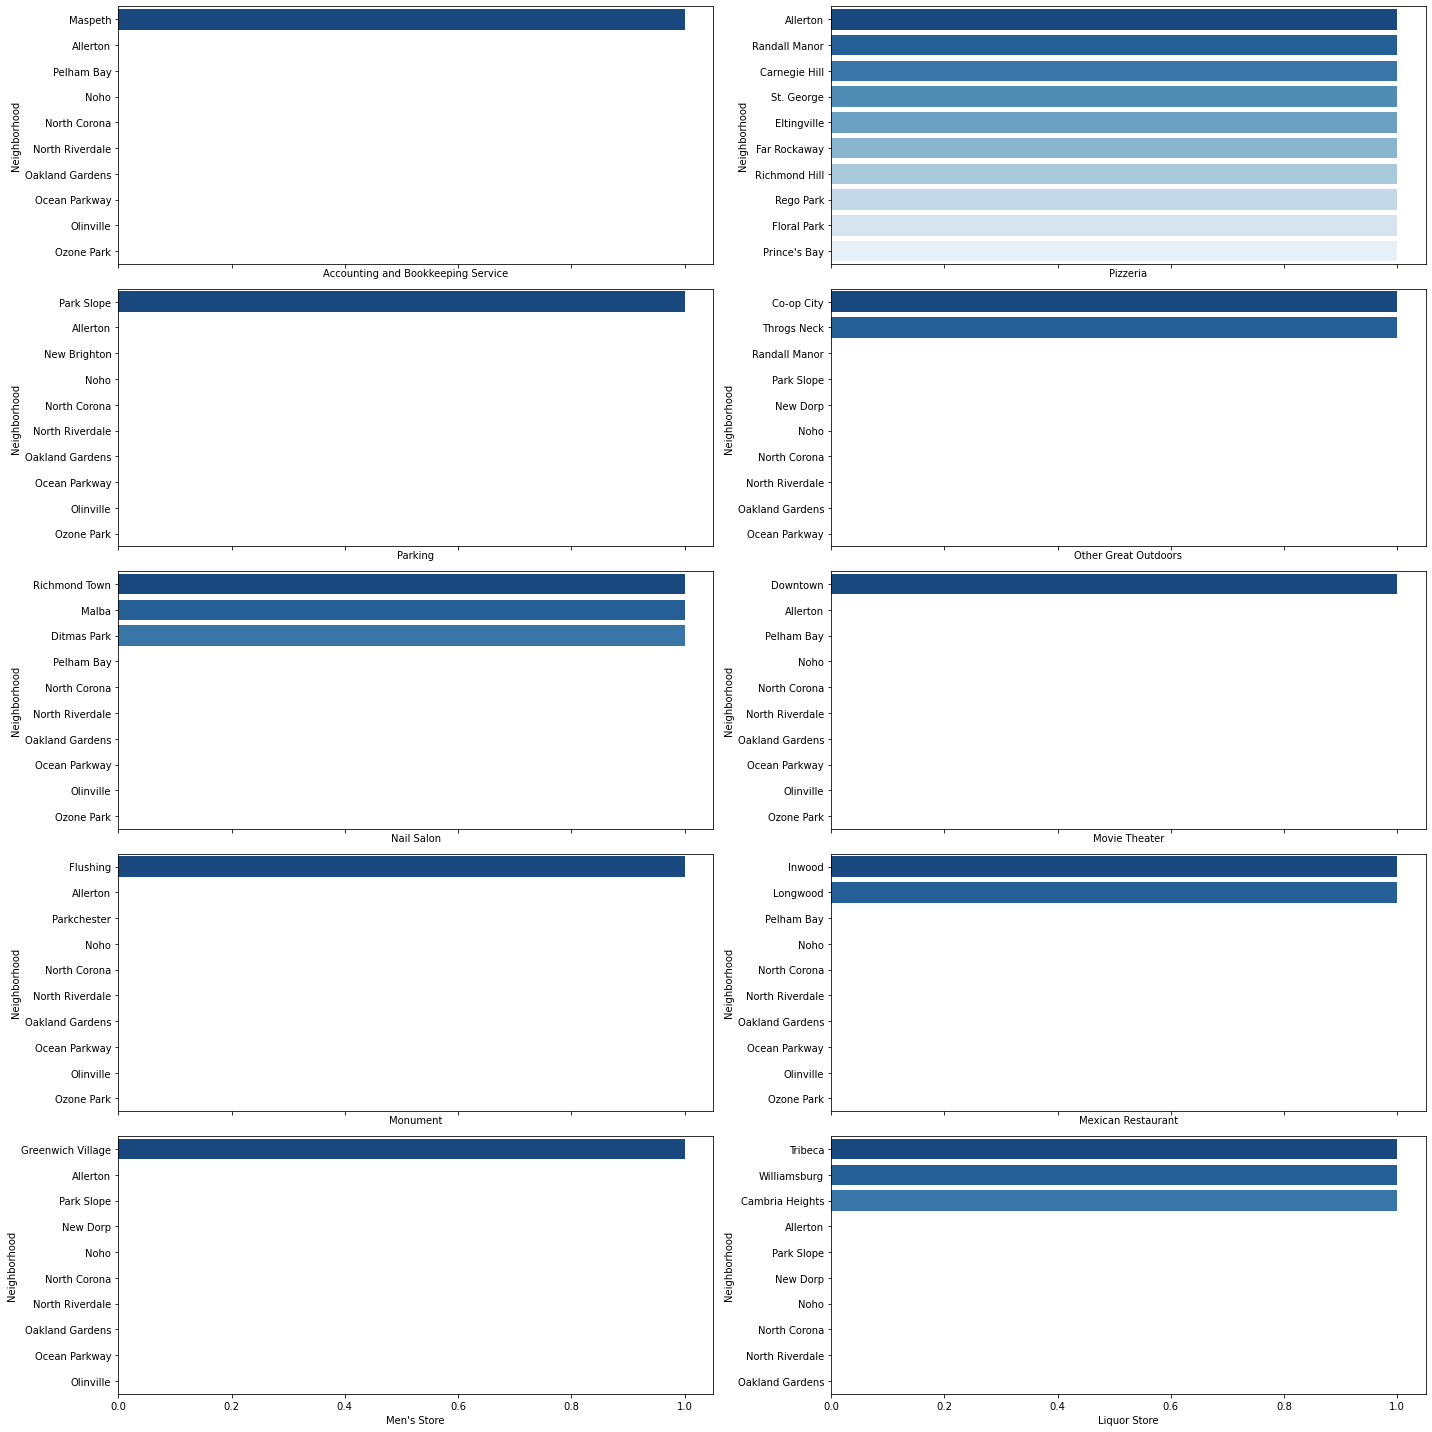

In [216]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.savefig('venue.png')
plt.show();

In [92]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Accounting and Bookkeeping Service,Agriculture and Forestry Service,American Restaurant,Art Museum,Arts and Crafts Store,Asian Restaurant,Automotive Retail,BBQ Joint,Bank,...,Sporting Goods Retail,Stationery Store,Steakhouse,Sushi Restaurant,Swimming Pool,Taiwanese Restaurant,Thai Restaurant,Theater,Vegan and Vegetarian Restaurant,Video Games Store
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Astoria Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [94]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [95]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [96]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon
1,Arden Heights,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors
2,Arlington,General Contractor,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors
3,Arrochar,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon
4,Astoria Heights,Landmarks and Outdoors,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors


In [97]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)


/var/folders/r_/261vq98s0r17yqfhxjgdz4980000gn/T/ipykernel_25423/1601191859.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)


In [98]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

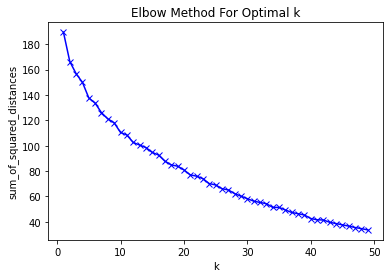

In [215]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show();

In [101]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

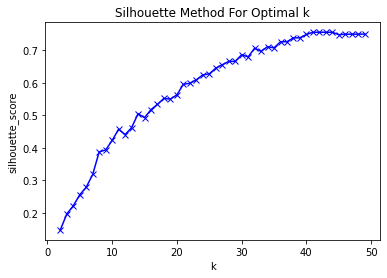

In [214]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.savefig('silo.png')

plt.show()
# plt.savefig('silo.png')


In [203]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({0: 122, 6: 26, 7: 10, 3: 10, 4: 10, 1: 7, 5: 7, 2: 5})


In [204]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [205]:
neighborhoods_venues_sorted.head(5)


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Allerton,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon
1,3,Arden Heights,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors
2,0,Arlington,General Contractor,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors
3,1,Arrochar,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon
4,0,Astoria Heights,Landmarks and Outdoors,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors


In [206]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(df.set_index('neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
0,1,Allerton,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Bronx,40.865788,-73.859319
1,3,Arden Heights,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Staten Island,40.549286,-74.185887
2,0,Arlington,General Contractor,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Staten Island,40.635325,-74.165104
3,1,Arrochar,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Staten Island,40.596313,-74.067124
4,0,Astoria Heights,Landmarks and Outdoors,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Queens,40.770317,-73.894680


In [207]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['latitude'], nyc_merged['longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-4],
        fill=True,
        fill_color=rainbow[cluster-4],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save("map.html")
map_clusters

In [208]:
required_column_indices = [2,3,1,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,1,7]

In [209]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
2,Arlington,General Contractor,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Staten Island,40.635325,-74.165104
4,Astoria Heights,Landmarks and Outdoors,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Queens,40.770317,-73.894680
5,Bay Terrace,Plaza,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Queens,40.782843,-73.776802
5,Bay Terrace,Plaza,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Staten Island,40.553988,-74.139166
8,Bayswater,Automotive Retail,Accounting and Bookkeeping Service,Liquor Store,Pest Control Service,Parking,Queens,40.611322,-73.765968


In [210]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Plaza                   4
Fast Food Restaurant    4
BBQ Joint               4
Nail Salon              3
Brewery                 3
                       ..
Concert Hall            1
Speakeasy               1
Dog Park                1
Bank                    1
Daycare                 1
Name: 1st Most Common Venue, Length: 71, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    91
Pizzeria                              10
Liquor Store                           2
Playground                             1
Latin American Restaurant              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bay Terrace      2
Arlington        1
New Brighton     1
Richmond Town    1
Ravenswood       1
                ..
Fordham          1
Flushing         1
Flatiron         1
Fieldston        1
Yorkville        1
Name: Neighborhood, Length: 104, dtype: int64
---------------------------------------------
Queens           30


In [173]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
0,Allerton,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Bronx,40.865788,-73.859319
3,Arrochar,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Staten Island,40.596313,-74.067124
10,Bedford Stuyvesant,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Brooklyn,40.687232,-73.941785
13,Belmont,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Bronx,40.857277,-73.888452
14,Bensonhurst,Pizzeria,Accounting and Bookkeeping Service,Parking,Other Great Outdoors,Nail Salon,Brooklyn,40.611009,-73.995180


In [174]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizzeria    26
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    26
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Allerton              1
Arrochar              1
Van Nest              1
Unionport             1
St. George            1
Richmond Hill         1
Rego Park             1
Randall Manor         1
Prince's Bay          1
Ozone Park            1
Mill Basin            1
Midwood               1
Marble Hill           1
Jamaica Center        1
Howard Beach          1
Holliswood            1
Floral Park           1
Far Rockaway          1
Eltingville           1
Egbertville           1
Carnegie Hill         1
Bronxdale             1
Bensonhurst           1
Belmont               1
Bedford Stuyvesant    1
West Brighton         1
Name: Neighborhood, dtype: int64
---------------------------------------------
Queens           8
Staten Island    7
Bronx            5
Brooklyn

In [175]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
9,Bedford Park,Deli,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Bronx,40.870185,-73.885512
24,Brookville,Deli,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Queens,40.660003,-73.751753
108,Marine Park,Deli,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Brooklyn,40.609748,-73.931344
120,Morris Park,Deli,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Bronx,40.847549,-73.850402
140,Port Richmond,Deli,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Staten Island,40.633669,-74.129434


In [176]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Deli    10
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    10
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bedford Park        1
Brookville          1
Marine Park         1
Morris Park         1
Port Richmond       1
Richmond Valley     1
Silver Lake         1
South Ozone Park    1
Stapleton           1
Whitestone          1
Name: Neighborhood, dtype: int64
---------------------------------------------
Staten Island    4
Queens           3
Bronx            2
Brooklyn         1
Manhattan        0
Name: borough, dtype: int64
---------------------------------------------


In [177]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
1,Arden Heights,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Staten Island,40.549286,-74.185887
25,Bulls Head,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Staten Island,40.609592,-74.159409
45,Douglaston,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Queens,40.766846,-73.742498
67,Fresh Meadows,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Queens,40.734394,-73.782713
69,Georgetown,Drugstore,Accounting and Bookkeeping Service,Pizzeria,Parking,Other Great Outdoors,Brooklyn,40.623845,-73.916075


In [178]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Drugstore    7
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    7
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Arden Heights    1
Bulls Head       1
Douglaston       1
Fresh Meadows    1
Georgetown       1
Manor Heights    1
Starrett City    1
Name: Neighborhood, dtype: int64
---------------------------------------------
Staten Island    3
Brooklyn         2
Queens           2
Bronx            0
Manhattan        0
Name: borough, dtype: int64
---------------------------------------------


In [146]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
36,Claremont Village,Grocery Store / Supermarket,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Bronx,40.831428,-73.901199
39,Concord,Grocery Store / Supermarket,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Staten Island,40.604473,-74.084024
47,East Flatbush,Grocery Store / Supermarket,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Brooklyn,40.641718,-73.936103
50,Edenwald,Grocery Store / Supermarket,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Bronx,40.884561,-73.848083
130,Ocean Parkway,Grocery Store / Supermarket,Accounting and Bookkeeping Service,Liquor Store,Parking,Other Great Outdoors,Brooklyn,40.613060,-73.968367


In [179]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Grocery Store / Supermarket    10
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    10
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Claremont Village     1
Concord               1
East Flatbush         1
Edenwald              1
Ocean Parkway         1
Pelham Bay            1
Pelham Parkway        1
Rochdale              1
Soundview             1
University Heights    1
Name: Neighborhood, dtype: int64
---------------------------------------------
Bronx            6
Brooklyn         2
Queens           1
Staten Island    1
Manhattan        0
Name: borough, dtype: int64
---------------------------------------------


In [181]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
65,Fort Hamilton,Sushi Restaurant,Accounting and Bookkeeping Service,Latin American Restaurant,Parking,Other Great Outdoors,Brooklyn,40.614768,-74.031979
100,Lindenwood,Sushi Restaurant,Accounting and Bookkeeping Service,Latin American Restaurant,Parking,Other Great Outdoors,Queens,40.663918,-73.849638
123,Murray Hill,Sushi Restaurant,Fast Food Restaurant,Accounting and Bookkeeping Service,Liquor Store,Parking,Manhattan,40.748303,-73.978332
123,Murray Hill,Sushi Restaurant,Fast Food Restaurant,Accounting and Bookkeeping Service,Liquor Store,Parking,Queens,40.764126,-73.812763
194,Woodrow,Sushi Restaurant,Accounting and Bookkeeping Service,Latin American Restaurant,Parking,Other Great Outdoors,Staten Island,40.541968,-74.205246


In [182]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Sushi Restaurant    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    3
Fast Food Restaurant                  2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Murray Hill      2
Fort Hamilton    1
Lindenwood       1
Woodrow          1
Name: Neighborhood, dtype: int64
---------------------------------------------
Queens           2
Brooklyn         1
Manhattan        1
Staten Island    1
Bronx            0
Name: borough, dtype: int64
---------------------------------------------


In [150]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
33,Chinatown,Chinese Restaurant,Accounting and Bookkeeping Service,Men's Store,Pest Control Service,Parking,Manhattan,40.715618,-73.994279
81,Homecrest,Chinese Restaurant,Accounting and Bookkeeping Service,Men's Store,Pest Control Service,Parking,Brooklyn,40.598525,-73.959185
96,Kingsbridge Heights,Chinese Restaurant,Accounting and Bookkeeping Service,Men's Store,Pest Control Service,Parking,Bronx,40.870392,-73.901523
101,Little Italy,Chinese Restaurant,Accounting and Bookkeeping Service,Men's Store,Pest Control Service,Parking,Manhattan,40.719324,-73.997305


In [183]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant    4
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Accounting and Bookkeeping Service    4
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Chinatown              1
Homecrest              1
Kingsbridge Heights    1
Little Italy           1
Name: Neighborhood, dtype: int64
---------------------------------------------
Manhattan        2
Bronx            1
Brooklyn         1
Queens           0
Staten Island    0
Name: borough, dtype: int64
---------------------------------------------


In [184]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,borough,latitude,longitude
21,Broadway Junction,Playground,Pizzeria,Parking,Other Great Outdoors,Nail Salon,Brooklyn,40.677861,-73.903317
63,Forest Hills,Playground,Pizzeria,Parking,Other Great Outdoors,Nail Salon,Queens,40.725264,-73.844475
105,Manhattan Beach,Playground,Pizzeria,Parking,Other Great Outdoors,Nail Salon,Brooklyn,40.577914,-73.943537
111,Middle Village,Playground,Pizzeria,Parking,Other Great Outdoors,Nail Salon,Queens,40.716415,-73.881143
142,Prospect Heights,Playground,Pizzeria,Parking,Other Great Outdoors,Nail Salon,Brooklyn,40.676822,-73.964859


In [185]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Playground    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizzeria    5
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Broadway Junction    1
Forest Hills         1
Manhattan Beach      1
Middle Village       1
Prospect Heights     1
Name: Neighborhood, dtype: int64
---------------------------------------------
Brooklyn         3
Queens           2
Bronx            0
Manhattan        0
Staten Island    0
Name: borough, dtype: int64
---------------------------------------------


In [155]:
import pickle
with open('merged_house.pkl', 'rb') as f:
    merged_house = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")

---Dataframe Existed and Deserialized---


In [156]:
merged_house

,neighborhood,mean_x,borough
0,Allerton,1625.000000,Bronx
1,Arden Heights,2099.274673,Staten Island
2,Astoria,1883.333333,Queens
3,Auburndale,1916.666667,Queens
4,Bath Beach,2133.333333,Brooklyn
...,...,...,...
219,Woodhaven,1702.333333,Queens
220,Woodlawn Heights,1939.795620,NaN
221,Woodside,1807.666667,Queens
222,Woodstock,1999.274673,NaN


In [186]:
merged_house.to_excel('merged_house.xlsx')